In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import pymc3 as pm
from quap import quap
import arviz as az
import statsmodels.api as sm
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]
    

In [4]:
d["age_minus_min"] = d.age - d.age.min()

In [6]:
d2.age.std()

15.96785507612595

In [9]:
with pm.Model() as model_name:
    a = pm.Normal("a", mu=170, sd=40)
    b = pm.Normal("b", mu=0, sd=5)
    sigma = pm.Exponential("sigma", lam=1)
    mu = a + b*(d2.weight-d2.weight.mean())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    

In [ ]:
x_mean_centered = x - x.mean()

In [ ]:
x_min_centered = x - x.min()

In [ ]:
x_standardized = (x - x.mean())/x.std()

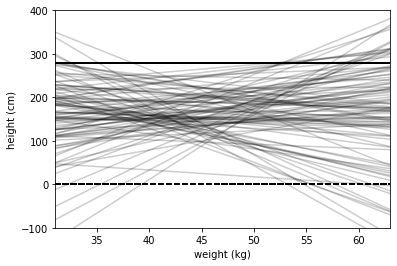

In [7]:
np.random.seed(2971)
N = 100  # 100 lines
a = st.norm.rvs(170, 40, N)
b = st.norm.rvs(0, 5, N)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    plt.plot(x,a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    plt.xlim(d2.weight.min(), d2.weight.max())
    plt.ylim(-100, 400)
    plt.axhline(0, c="k", ls="--")
    plt.axhline(280, c="k")
    plt.xlabel("weight (kg)")
    plt.ylabel("height (cm)")
plt.show()

In [10]:
with model_name:
    idata,posterior = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [12]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.598,0.267,154.150,155.002
b,0.905,0.042,0.839,0.972
sigma,5.037,0.189,4.734,5.335


array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

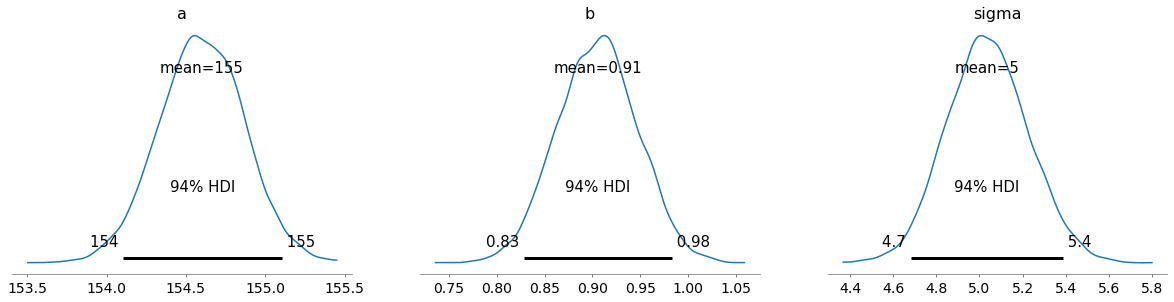

In [21]:
az.plot_posterior(idata)

In [22]:
samples.head()

,chain,draw,a,b,sigma
0,0,0,154.237071,0.926522,4.719696
1,0,1,154.598101,0.886784,4.831440
2,0,2,154.458978,0.896395,4.893035
3,0,3,154.765392,0.886530,5.050475
4,0,4,154.637788,0.968503,5.120308


In [60]:
# Load data
data = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

In [26]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [82]:
with pm.Model() as m_div1:
    a = pm.Exponential("a", lam=5)
    b = pm.Normal("b", mu=0, sd=5)
    sigma = pm.Exponential("sigma", lam=1)
    mu = a + b*data.Marriage
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=data.Divorce)
    idata,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


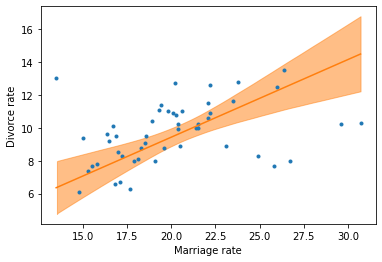

In [83]:
d_seq = np.linspace(data.Marriage.min(), data.Marriage.max(), 100)
mu_pred = np.zeros((len(d_seq), len(samples)))
for i, d in enumerate(d_seq):
    mu_pred[i] = samples["a"] + samples["b"] * d
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
plt.plot(data.Marriage,data.Divorce,".")
ax = az.plot_hdi(d_seq, mu_pred.T)
plt.plot(data_seq, mu_mean)
ax.set_xlabel("Marriage rate")
ax.set_ylabel("Divorce rate");

In [84]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

In [85]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [96]:
with pm.Model() as m_ageM:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    idata_A,dist = quap(vars=[a,bA,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

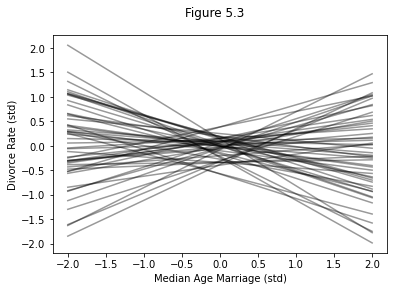

In [87]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + b * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


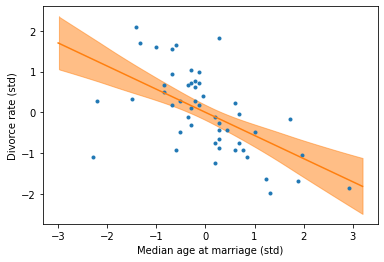

In [89]:
d_seq = np.linspace(-3, 3.2, 30)
mu_pred = np.zeros((len(d_seq), len(samples)))
for i, d in enumerate(d_seq):
    mu_pred[i] = samples["a"] + samples["bA"] * d
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
plt.plot(data.MedianAgeMarriage_std,data.Divorce_std,".")
ax = az.plot_hdi(d_seq, mu_pred.T)
plt.plot(d_seq, mu_mean)
ax.set_xlabel("Median age at marriage (std)")
ax.set_ylabel("Divorce rate (std)");

In [105]:
with pm.Model() as m_div2:
    a = pm.Normal("a", mu=0, sd=0.2)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", lam=1)
    mu = a + bM*data.Marriage_std
    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed=data.Divorce_std)
    idata_M,dist = quap(vars=[a,bM,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [94]:
with pm.Model() as m_age_mrate:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"] + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    idata_both,dist = quap(vars=[a,bA,bM,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [107]:
az.summary(idata_both, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.000,0.098,-0.161,0.150
bA,-0.613,0.153,-0.868,-0.382
bM,-0.066,0.151,-0.300,0.182
sigma,0.785,0.077,0.663,0.907


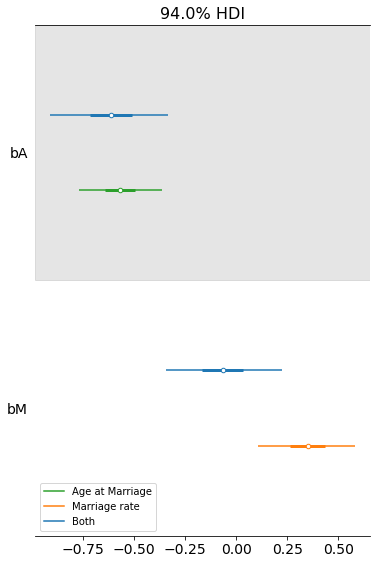

In [106]:
az.plot_forest(
    [
        idata_both,
        idata_M,
        idata_A,
    ],
    model_names=["Both", "Marriage rate", "Age at Marriage"],
    var_names=["bA", "bM"],
);